In [1]:
import numpy as np
import pandas as pd
import math

from typing import Tuple
import src.hdmm.workload as workload
import src.census_workloads as census
from src.workload_selection import workload_selection
import online_workloads as online_workloads

In [121]:
def pmw_naive(workload, x, analyst_labels, T, eps=0.01, total_k=None, 
         show_messages=False, to_return='error', show_plot=False, show_failure_step=False, eta = None,
             count_threshold=0.1):
    """
    Implement Private Multiplicative Weights Mechanism (PMW) on a workload of
    linear queries where analysts can run out of privacy budget if they use too much of others'. 
    
    In other words, all analysts share from the same privacy budget. 
    
    Last Updated: 4-23-2022

    Algorithm Parameters: 
    - workload = workload of queries (M x k numpy array)
    - x = true database (M x 1 numpy array)
    - T = update threshold
    - eps = privacy budget
    - total_k = total number of update steps alloted for the entire group
    - analyst_labels = list of analyst names corresponding to each query in the workload
    
    Output Controls: 
    - show_messages argument determines whether the function will print information such as 
    error scale, threshold, update steps used, etc.
    - to_return argument determines what the function will return. 
        - if 'pd', pmw() returns pandas df with test data for each 
        query in the workload(showing query, d_t_hat, updated, algo_ans, real_ans, 
        abs_error, rel_error). 
        - if 'error', pmw() returns a dictionary for the average absolute error for each analyst
        - if 'pct_ans', pmw() returns a dictionary for the percent of queries answered that meets
        the accuracy threshold set by count_threshold
    - show_plot - T/F whether the function will display a plot
    - show_failure_step - T/F whether function prints what step failure mode is reached
    - count_threshold - this is for the to_return = 'pct_ans' setting. It is the min error threshold 
    that a query answer for us to count the answer as "reasonable" as opposed to "bot". The default
    is 0.1. This functions as another way to  measure the accuracy of the queries that is more similar 
    to how our other functions; i.e., cache and reconstruct either returns an accurate answer or "bot".
    """ 
    
    # initialize constants
    m = x.size  # database len
    n = x.sum()
    if(eta == None):
        eta = (math.log(m, np.e) / ((math.sqrt(n))) )
    delta = 1 / (n * math.log(n, np.e))
    x_norm = x / np.sum(x)
    
    # initialize synthetic databases at time 0 (prior to any queries)
    x_t = np.ones(m) / m
    y_t = np.ones(m) / m

    # initialize tracker lists to construct pandas dataframe at the end 
    x_list = [x_t] # create a list of x_t synthetic database at every time step
    update_list = []
    update_count = 0
    pmw_answers = []
    update_times = [] # record times that database is updated
    d_t_hat_list = []
    
    # initialize total_k, the total number of update steps if not default
    if total_k == None:
        total_k = round(n * math.log(math.sqrt(m)) / 770) #770
        #print(f'{total_k=}')
    
    def lazy_round():
        """
        "Lazy Round" of querying using the stored synthetic database, x_t, in list x_list.
        
        We call this the lazy round because it is contrasted with the updated step where we update the 
        sythetic database and answer the query using the real database.
        """
        update_list.append('no')
        answer = np.dot(query, x_list[time])
        if answer < 0:
            pmw_answers.append(0)
        else: 
            pmw_answers.append(answer)
        x_list.append(x_list[time])
    
    # inititate first instance of SVT with half the budget and k updates; will be reset in the main loop
    SVTtrigger = False 
    SVTepsilon1 = ((eps/2)/2)
    SVTepsilon2 = ((eps/2)/2)
    rho = np.random.laplace(loc=0, scale=(1/SVTepsilon1), size=1)[0]
    #print(rho + T)
    
    
    for time, query in enumerate(workload):
        
        analyst = analyst_labels[time]
        
        # Do one round of sparse vector technique; compute noisy answer by adding Laplacian noise
        A_t = np.random.laplace(loc=0, scale=(total_k/SVTepsilon2), size=1)[0]
        a_t_hat = (np.dot(query, x_norm)*n ) + A_t
        d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
        
        # LAZY ROUND: QUERY USING THE SYNTHETIC DATABASE
        if (abs(d_t_hat) <= T + rho):
            d_t_hat_list.append(d_t_hat)
            lazy_round()

        # UPDATE ROUND: UPDATE SYNTHETIC DATABASE AND RETURN NOISY ANSWER, A_T-HAT
        else:
            # noise
            A_t = np.random.laplace(loc=0, scale=(2*total_k/eps), size=1)[0]
            
            # noisy answer
            a_t_hat = (np.dot(query, x_norm)*n ) + A_t
            d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
            d_t_hat_list.append(d_t_hat)
            update_times.append(time)
            
            # step a
            if d_t_hat < 0:
                r_t = query
            else:
                r_t = np.ones(m) - query
            for i in range(len(y_t)):
                y_t[i] = x_list[time][i] * math.exp(-( eta * r_t[i]))# eta is the learning rate
            
            # step b
            x_t = y_t / np.sum(y_t)
            update_count = update_list.count('yes')
            
            # if threshold for num updates is reached, just do a lazy round (synthetic database) answer
            if total_k == 0: 
                if show_failure_step:
                    print(f'Failure mode reached at query number {time}: {query}')
                lazy_round()
                
            # if there are still update steps that the analyst can use, 
            # 1. update the synthetic database
            # 2. answer the query using the noisy answer from the database itself 
            else: 
                x_list.append(x_t)
                update_list.append('yes') # increment number of updates counter
                answer = a_t_hat / np.sum(x)
                
                if answer < 0:
                    pmw_answers.append(0)
                else: 
                    pmw_answers.append(answer)
                
                total_k -= 1 # use one of the total update steps
        
        #print(f'{x_list[time] - x_list[time - 1]=}')
        
        
    update_count = update_list.count('yes')      

    # calculate error
    real_ans = np.matmul(workload, x_norm)
    abs_error = np.abs(pmw_answers - real_ans)
    rel_error = np.abs(abs_error / np.where(real_ans == 0, 0.000001,
                                                real_ans))
    
    if show_messages:
        np.set_printoptions(suppress=True)
        """Print inputes/outputs to analyze each query"""
        print(f'Original database: {x}\n')
        print(f'Synthetic Database (after) = {x_list[len(x_list) - 1] * sum(x)}\n')
        print(f'Normalized database: {x_norm}\n')
        print(f'Synthetic Database (before) = {x_list[0]}\n')
        print(f'Synthetic Database (after, norm) = {x_list[len(x_list) - 1]}\n')
        print(f'Difference btw. Final Synthetic and true database = {x_list[len(x_list) - 1] - x_norm}\n')
        print(f'Update Count = {update_count}\n')
        print(f'{T=}\n')
        print(f'Error Scale Query Answer= {2*((2*total_k/eps)**2)}\n')
        print(f'Error Scale SVT= {2*((2*total_k/SVTepsilon2)**2)}\n')
        print(f'Update Parameter Scale = {eta}\n')
        print(f'{delta=}\n')
        
    if show_plot: 
        plt.title('Error across queries:')
        rel_line, = plt.plot(rel_error, label='Relative Error')
        abs_line, = plt.plot(abs_error, label='Absolute Error')
        for xc in update_times:
            plt.axvline(x=xc, color='red', label='Update Times', linestyle='dashed')
        plt.legend(handles=[abs_line,rel_line])
        plt.xticks(range(0, len(workload), round(len(workload)/5)))
    
    if to_return == "pd":
        # hacky fix: remove the first synthetic database to keep length of lists consistent with the
        # other lists that comprise of the pandas dataframe
        x_list.pop(0).tolist() 
        d = {
            'algo_ans': pmw_answers,
            'real_ans': real_ans.tolist(),
            'queries': workload.tolist(), 
            'updated': update_list,
            'abs_error': abs_error,               
            'rel_error': rel_error,
            'synthetic database': x_list,
            'analyst': analyst_labels,
            'd_t_hat': d_t_hat_list, 

             }
        test_data = pd.DataFrame(data=d)
        #test_data = test_data.round(3)
        return test_data
    
    if to_return == "error":
        d = {'analyst': analyst_labels,
             'abs_error': abs_error,               
             'rel_error': rel_error,}
        data = pd.DataFrame(data=d)
        data = data.round(3)
        
        analyst_error = {}
        for analyst in list(sorted(analyst_labels)):
            analyst_error[analyst] = data[data.analyst==analyst]['abs_error'].sum()
        return analyst_error
    
    if to_return == "tse":
        d = {'analyst': analyst_labels,
             'abs_error': abs_error,}
        data = pd.DataFrame(data=d)
        data['squared_err'] = data['abs_error'] ** 2
        
        analyst_error = {}
        for analyst in list(sorted(analyst_labels)):
            analyst_error[analyst] = data[data.analyst==analyst]['abs_error'].sum()
        return analyst_error
    
    if to_return == "pct_ans":
        count_threshold = 0.3
        d = {'analyst': analyst_labels,
             'abs_error': abs_error,}
        data = pd.DataFrame(data=d)
                
        pct_answered = {}
        for analyst in list(sorted(analyst_labels)):
            pct_answered[analyst] = data[(data['abs_error'] < threshold) & (data.analyst==analyst)]['abs_error'].count()/len(data)
        return pct_answered

In [119]:
data_ex = pmw_naive(workload = large_w, 
                          x = x_race[:64], 
                          analyst_labels = ['A'] * len(large_w), 
                          eps=1, 
                          T=40, 
                          total_k = 1000, 
                          show_messages=False, to_return='num_ans')

data_ex

{'A': 0.7521875}

In [113]:
threshold = 0.01
data_test[(data_test['abs_error'] < threshold) & (data_test.analyst=='A')]['abs_error'].count()/len(data_test)
data_test

,algo_ans,real_ans,queries,updated,abs_error,rel_error,synthetic database,analyst,d_t_hat
0,0.023280,0.020096,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes,0.003184,0.158451,"[0.016078087069513525, 0.015617808141753755, 0...",A,156.937970
1,0.000000,0.016242,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes,0.016242,1.000000,"[0.01608527883295217, 0.015177491838797163, 0....",A,-3615.549842
2,0.065049,0.013901,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes,0.051148,3.679403,"[0.01607787521561373, 0.015170506051177394, 0....",A,1013.290415
3,0.034783,0.011267,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes,0.023515,2.087069,"[0.016070478410508092, 0.01516352669133602, 0....",A,392.920773
4,0.000000,0.009853,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",yes,0.009853,1.000000,"[0.01607766336729687, 0.015170306158708409, 0....",A,-621.224725
...,...,...,...,...,...,...,...,...,...
6395,0.012980,0.005414,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no,0.007566,1.397521,"[0.01893542490154431, 0.01590703724762008, 0.0...",A,-155.124879
6396,0.016376,0.005317,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no,0.011059,2.080160,"[0.01893542490154431, 0.01590703724762008, 0.0...",A,-226.737475
6397,0.015009,0.005463,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no,0.009546,1.747508,"[0.01893542490154431, 0.01590703724762008, 0.0...",A,-195.720863
6398,0.013757,0.005512,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",no,0.008245,1.495948,"[0.01893542490154431, 0.01590703724762008, 0.0...",A,-169.042180


In [3]:
import matplotlib.pyplot as plt

def plot_databases(data, y_upper=0.05):
    """
    Plot True and Synthetic database side by side
    
    Input: 
    - data = pd.DataFrame returned from pmw()
    - y_upper = y upperbound on the plot
    """
    y_upper = 0.05

    x1 = range(64)
    y1 = x_race[:64] / sum(x_race[:64])

    final_synthdb = data.iloc[len(data) - 1, 6]
    x2 = range(64)
    y2 = final_synthdb

    plt.subplot(1, 2, 1)
    plt.plot(x1, y1, color ="red")
    plt.ylim([0, y_upper])
    plt.title('True Database')

    plt.subplot(1, 2, 2)
    plt.plot(x2, y2, color ="red")
    plt.title('A tale of 2 subplots')
    plt.ylim([0, y_upper])
    plt.title('Final Synthetic Database')


    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.show()


In [4]:
n=64
ten_identity_q = np.vstack((online_workloads.identity(n), 
                            online_workloads.identity(n),
                            online_workloads.identity(n),
                            online_workloads.identity(n),
                            online_workloads.identity(n),
                            online_workloads.identity(n),
                            online_workloads.identity(n),
                            online_workloads.identity(n),
                            online_workloads.identity(n),
                            online_workloads.identity(n)))

large_w = np.vstack((ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q, 
                               ten_identity_q))

print(f'{large_w.shape=}')

large_w.shape=(6400, 64)


In [5]:
data_path = "migration_tworace.csv"
x_race = pd.read_csv(data_path, header=None).to_numpy().T[1] # truncate to first 64
x_race

array([412, 333, 285, 231, 202, 174, 160, 142, 146, 149, 145, 181, 174,
       190, 213, 287, 372, 499, 619, 715, 785, 821, 822, 816, 799, 742,
       717, 697, 658, 593, 564, 519, 447, 403, 388, 365, 336, 306, 311,
       289, 261, 231, 213, 196, 194, 170, 175, 168, 149, 142, 131, 119,
       112, 118, 114, 116, 112, 114, 106, 111, 109, 112, 113, 109, 104,
       108, 108,  94,  91,  81,  81,  72,  68,  63,  56,  46,  41,  38,
        34,  28,  23,  22,  18,  18,  16,  41])

In [94]:
n=64
W_name = ['identity', 'total', 'H2', 'race1', 'race2', 'race3', 'custom', 'prefix_sum']
W_lst = [online_workloads.identity(n), online_workloads.total(n), online_workloads.H2(n), online_workloads.race1(), online_workloads.race2(), online_workloads.race3(), online_workloads.custom(n), online_workloads.prefix_sum(n)]

c = np.random.randint(len(W_lst))
final_W = W_lst[c] 

data_test = pmw_naive(workload = large_w, 
                          x = x_race[:64], 
                          analyst_labels = ['A'] * len(large_w), 
                          eps=1, 
                          T=40, 
                          total_k = 1000, 
                          show_messages=False, to_return='pd')

0       0.003184
1       0.016242
2       0.051148
3       0.023515
4       0.009853
          ...   
6395    0.007566
6396    0.011059
6397    0.009546
6398    0.008245
6399    0.009693
Name: abs_error, Length: 6400, dtype: float64

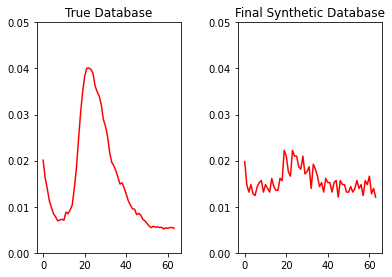

In [7]:
plot_databases(data_test)

# Scheduler

In [8]:
def skewed_scheduler(a: np.ndarray, b: np.ndarray, p: int) -> Tuple: 
    """
    Schedules Alice's queries with a probability of p and Bob's queries with a probability of (p - 1).
    
    Returns new workload of queries (2x2 np.array) and analyst labels (python list). 
    
    p: prob of scheduling Alice's queries
    a: alice's workload
    b: bob's workload
    """
    
    W = []
    analyst_labels = []
    
    if a.shape[1] != b.shape[1]:
         raise TypeError("a and b dimensions don't match")
    
    a_pointer = 0
    b_pointer = 0
    
    while(a_pointer < len(a) and b_pointer < len(b)):
        if np.random.random() < p:
            W.append(a[a_pointer])
            a_pointer += 1
            analyst_labels.append('A')
        else: 
            W.append(b[b_pointer])
            b_pointer += 1
            analyst_labels.append('B')
    
    if a_pointer == len(a):
        W = np.vstack((W, b[b_pointer:]))
        analyst_labels += ['B' for i in range(b_pointer, len(b))]
    if b_pointer == len(b): 
        W = np.vstack((W, a[a_pointer:]))
        analyst_labels += ['A' for i in range(a_pointer, len(a))]
    
    W = np.array(W)
    return W, analyst_labels

a_ex = np.array([[1, 2, 3],
             [4, 5, 6],
             [7, 8, 9]])

b_ex = np.array([[11, 22, 33],
             [44, 55, 66],
             [77, 88, 99]])
    
skewed_scheduler(a_ex, b_ex, 0.5)

(array([[ 1,  2,  3],
        [ 4,  5,  6],
        [11, 22, 33],
        [44, 55, 66],
        [ 7,  8,  9],
        [77, 88, 99]]),
 ['A', 'A', 'B', 'B', 'A', 'B'])

In [9]:
skewed_scheduler(a_ex, b_ex, 1)

(array([[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [11, 22, 33],
        [44, 55, 66],
        [77, 88, 99]]),
 ['A', 'A', 'A', 'B', 'B', 'B'])

In [10]:
skewed_scheduler(a_ex, b_ex, 0.9)

(array([[ 1,  2,  3],
        [ 4,  5,  6],
        [11, 22, 33],
        [ 7,  8,  9],
        [44, 55, 66],
        [77, 88, 99]]),
 ['A', 'A', 'B', 'A', 'B', 'B'])

In [11]:
skewed_scheduler(a_ex, b_ex, 0.8)

(array([[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [11, 22, 33],
        [44, 55, 66],
        [77, 88, 99]]),
 ['A', 'A', 'A', 'B', 'B', 'B'])

In [12]:
skewed_scheduler(a_ex, b_ex, 0.7)

(array([[ 1,  2,  3],
        [ 4,  5,  6],
        [11, 22, 33],
        [ 7,  8,  9],
        [44, 55, 66],
        [77, 88, 99]]),
 ['A', 'A', 'B', 'A', 'B', 'B'])

In [13]:
skewed_scheduler(a_ex, b_ex, 0.6)

(array([[11, 22, 33],
        [ 1,  2,  3],
        [ 4,  5,  6],
        [44, 55, 66],
        [ 7,  8,  9],
        [77, 88, 99]]),
 ['B', 'A', 'A', 'B', 'A', 'B'])

In [14]:
skewed_scheduler(a_ex, b_ex, 0.5)

(array([[11, 22, 33],
        [44, 55, 66],
        [ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [77, 88, 99]]),
 ['B', 'B', 'A', 'A', 'A', 'B'])

# Motivating Experiment

In [15]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [16]:
# initialize workloads
W_lst = [online_workloads.identity(n), online_workloads.total(n), online_workloads.custom(n), online_workloads.prefix_sum(n), online_workloads.race1(), online_workloads.race2(), online_workloads.race3(),]
W_name = ['identity', 'total', 'H2', 'custom', 'prefix_sum', 'race1', 'race2', 'race3']

def motivating_exp(p, t):
    diff_lst=[]
    for i in range(t):
        # generate two identical workloads
        c = np.random.randint(len(W_lst))

        alice = W_lst[c]
        bob = W_lst[c]
        # skewed scheduler
        W, analyst_labels = skewed_scheduler(alice, bob, p)
        
        #if W_name[c] in ['race1', 'race2', 'race3']:
        #    database = x_race
        #else:
        database = x_race[:64]
        
        
        # PMW calculate error
        error_dict = pmw_naive(W, database, analyst_labels, eps=1, T=40, to_return='error')

        # subtract errors to get difference
        diff =  error_dict['B'] - error_dict['A']
        # append difference to list for this specific p
        diff_lst.append(diff)

    return diff_lst

In [18]:
df_alice_bob = pd.DataFrame(columns = ['p', 'analyst', 'error'])

In [19]:
def concatenate_practical(df, p, analyst, error):
    return pd.concat([df,
                pd.DataFrame({'p': [p], 
                              'analyst': [analyst],
                              'error': [error]
                             })], 
                ignore_index=True)

concatenate_practical(df_alice_bob, 0.5, 'A', 0.1)

,p,analyst,error
0,0.5,A,0.1


In [54]:
ex = pd.DataFrame(columns = ['p', 'analyst', 'error'])

def motivating_exp_nodiffs(df, p):
    diff_lst=[]
    # generate two identical workloads
    c = np.random.randint(len(W_lst))

    alice = W_lst[c]
    bob = W_lst[c]
    
    # skewed scheduler
    W, analyst_labels = skewed_scheduler(alice, bob, p)

    database = x_race[:64]

    # PMW calculate error
    error_dict = pmw_naive(W, database, analyst_labels, eps=1, T=40, to_return='error')

    df = concatenate_practical(df, p, 'A', error_dict['A'])
    df = concatenate_practical(df, p, 'B', error_dict['B'])

    return df

ex = motivating_exp_nodiffs(ex, 0.1)
#ex['analyst'] = ex['analyst'].replace({"A": "Alice", "B": "Bob"}, inplace=True)

ex['analyst'].loc[(ex['analyst'] == 'A')] = 'Alice'
ex['analyst'].loc[(ex['analyst'] == 'B')] = 'Bob'

ex['analyst']

0    Alice
1      Bob
Name: analyst, dtype: object

In [44]:
df_alice_bob = pd.DataFrame(columns = ['p', 'analyst', 'error'])

for i in range(500):
    if i in list(range(100, 1001, 50)): 
        print(f'{i} iterations have passed')
    for p in [i / 100 for i in range(50, 101, 5)]:
        df_alice_bob = motivating_exp_nodiffs(df_alice_bob, p)

df_alice_bob

100 iterations have passed
150 iterations have passed
200 iterations have passed
250 iterations have passed
300 iterations have passed
350 iterations have passed
400 iterations have passed
450 iterations have passed


,p,analyst,error
0,0.5,A,0.038
1,0.5,B,0.043
2,0.55,A,0.003
3,0.55,B,0.005
4,0.6,A,0.324
...,...,...,...
10995,0.9,B,0.004
10996,0.95,A,0.003
10997,0.95,B,0.0
10998,1.0,A,0.351


In [56]:
df_alice_bob['analyst'].loc[(df_alice_bob['analyst'] == 'A')] = 'Alice'
df_alice_bob['analyst'].loc[(df_alice_bob['analyst'] == 'B')] = 'Bob'

df_alice_bob

,p,analyst,error
0,0.5,Alice,0.038
1,0.5,Bob,0.043
2,0.55,Alice,0.003
3,0.55,Bob,0.005
4,0.6,Alice,0.324
...,...,...,...
10995,0.9,Bob,0.004
10996,0.95,Alice,0.003
10997,0.95,Bob,0.0
10998,1.0,Alice,0.351


In [ ]:
# return def instead with the number of yes and no's 

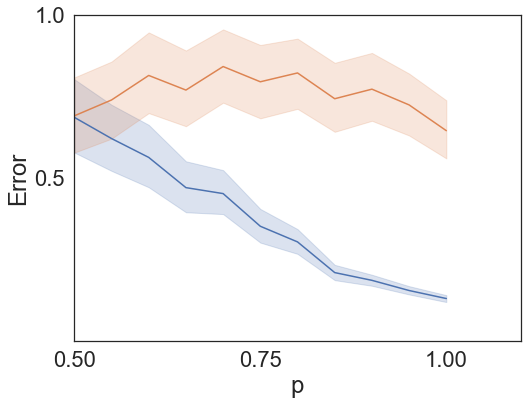

In [81]:
from matplotlib import rcParams
import seaborn as sns

sns.set(font_scale=2)
sns.set_style("white")

rcParams['figure.figsize'] = 8, 6

ax = sns.lineplot(data=df_alice_bob, x="p", y="error", hue='analyst')
ax.set_yticks([.5, 1])
ax.set_xticks([0.5, 0.75, 1])
ax.set_ylim([0, 1])
ax.set_xlim([.5, 1.1])

plt.legend([],[], frameon=False)

#ax.set_title("Alice receives less error than Bob with higher p", 
#            pad=15)
ax.set_xlabel('p')
ax.set_ylabel('Error')

artifacts_path = '/Users/albertsun/Projects/artifacts/'

#txt="Run on practical workloads with t=500 trials each \nusing Private Multiplicative Weights (Hardt 2010)"
#plt.figtext(0.53, -0.05, txt, wrap=True, horizontalalignment='left', fontsize=15)

plt.savefig(artifacts_path + "MotivatingExpError_point05.png")

# Compute pct queries answered with accuracy
Apr 23

In [150]:
def motivating_exp_pct_accurate(df, p):
    """ 
    Function to run motivating experiments with measurement bineg percent of queries answered accurately
    """
    diff_lst=[]
    # generate two identical workloads
    c = np.random.randint(len(W_lst))

    alice = W_lst[c]
    bob = W_lst[c]
    
    # skewed scheduler
    W, analyst_labels = skewed_scheduler(alice, bob, p)

    database = x_race[:64]

    # PMW calculate error
    pct_accurate_dict = pmw_naive(W, database, analyst_labels, eps=1, T=40, to_return='pct_ans', 
                          count_threshold=0.3)
    
    def concatenate_pct_acc(df, p, analyst, error):
        return pd.concat([df,
                    pd.DataFrame({'p': [p], 
                                  'analyst': [analyst],
                                  'pct_accurate': [error]
                                 })], 
                    ignore_index=True)
    
    df = concatenate_pct_acc(df, p, 'A', pct_accurate_dict['A'])
    df = concatenate_pct_acc(df, p, 'B', pct_accurate_dict['B'])

    return df

In [157]:
df_alice_bob_pct_accurate = pd.DataFrame(columns = ['p', 'analyst', 'pct_accurate'])

for i in range(500):
    if i in list(range(100, 1001, 10)): 
        print(f'{i} iterations have passed')
    for p in [i / 100 for i in range(50, 101, 5)]:
        df_alice_bob_pct_accurate = motivating_exp_pct_accurate(df_alice_bob_pct_accurate, p)

df_alice_bob_pct_accurate

100 iterations have passed
110 iterations have passed
120 iterations have passed
130 iterations have passed
140 iterations have passed
150 iterations have passed
160 iterations have passed
170 iterations have passed
180 iterations have passed
190 iterations have passed
200 iterations have passed
210 iterations have passed
220 iterations have passed
230 iterations have passed
240 iterations have passed
250 iterations have passed
260 iterations have passed
270 iterations have passed
280 iterations have passed
290 iterations have passed
300 iterations have passed
310 iterations have passed
320 iterations have passed
330 iterations have passed
340 iterations have passed
350 iterations have passed
360 iterations have passed
370 iterations have passed
380 iterations have passed
390 iterations have passed
400 iterations have passed
410 iterations have passed
420 iterations have passed
430 iterations have passed
440 iterations have passed
450 iterations have passed
460 iterations have passed
4

,p,analyst,pct_accurate
0,0.5,A,0.392857
1,0.5,B,0.364286
2,0.55,A,0.251969
3,0.55,B,0.232283
4,0.6,A,0.4375
...,...,...,...
10995,0.9,B,0.5
10996,0.95,A,0.337963
10997,0.95,B,0.185185
10998,1.0,A,0.414286


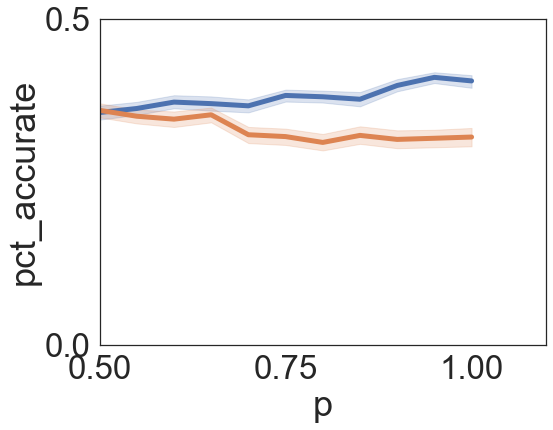

In [286]:
sns.set(font_scale=3)
sns.set_style("white")

ax = sns.lineplot(data=df_alice_bob_pct_accurate, x="p", y="pct_accurate", hue='analyst', lw=5)
ax.set_yticks([0, .5, 1])
ax.set_xticks([0.5, 0.75, 1])
ax.set_ylim([0, 0.5])
ax.set_xlim([.5, 1.1])

plt.legend([],[], frameon=False)

#ax.set_title("Alice receives less error than Bob with higher p", 
#            pad=15)
#ax.set_xlabel('p')
#ax.set_ylabel('% Answered Accurately')

artifacts_path = '/Users/albertsun/Projects/artifacts/'

#txt="Run on practical workloads with t=500 trials each \nusing Private Multiplicative Weights (Hardt 2010)"
#plt.figtext(0.53, -0.05, txt, wrap=True, horizontalalignment='left', fontsize=15)

plt.savefig(artifacts_path + "MotivatingExpAccCount.png")

# Empirical Interference
April 23

- for each analyst i, the ratio of the expected error for analyst j when all analysts are included to the case when excluding analyst i
- ratio of:
    - Err(Alice | Yes Bob) / Err(Alice | No Bob)
    - Err(Bob | Yes Alice) / Err(Bob | No Alice)

In [268]:
database = x_race[:64]
bob = W_lst[np.random.randint(len(W_lst))]
BwoA = pmw_naive(bob, database, ['B'] * len(bob), eps=1, T=40, to_return='error', 
                          count_threshold=0.3)['B']
BwoA

2.311

In [271]:
def motivating_exp_emp_int(df, p):
    """ 
    Function to run motivating experiments with measurement being empirical interference
    
    4-23-2022
    """
    diff_lst=[]
    # generate two identical workloads
    c = np.random.randint(len(W_lst))

    alice = W_lst[c]
    bob = W_lst[c]

    # calculate Bob's error with Alice
    W, analyst_labels = skewed_scheduler(alice, bob, p)
    database = x_race[:64]
    BwA = pmw_naive(W, database, analyst_labels, eps=1, T=40, to_return='error', 
                          count_threshold=0.3)['B']
    
    
    # BwoA = calculate Bob's error without Alice
    BwoA = pmw_naive(bob, database, ['B'] * len(bob), eps=1, T=40, to_return='error', 
                          count_threshold=0.3)['B']
    
    # prevent divide by 0 error, ignore
    if(BwoA != 0):
    
        # empirical interference
        emp_int = BwA / BwoA

        # cols: p, emp_int

        df = pd.concat([df,
                        pd.DataFrame({'p': [p], 
                                      'emp_int': [emp_int]
                                     })], 
                        ignore_index=True)
    
    return df

In [276]:
df_emp_int = pd.DataFrame(columns = ['p', 'emp_int'])

for i in range(200):
    if i in list(range(0, 1001, 10)): 
        print(f'{i} iterations have passed')
    for p in [i / 100 for i in range(50, 101, 5)]:
        df_emp_int = motivating_exp_emp_int(df_emp_int, p)

df_emp_int

0 iterations have passed
10 iterations have passed
20 iterations have passed
30 iterations have passed
40 iterations have passed
50 iterations have passed
60 iterations have passed
70 iterations have passed
80 iterations have passed
90 iterations have passed
100 iterations have passed
110 iterations have passed
120 iterations have passed
130 iterations have passed
140 iterations have passed
150 iterations have passed
160 iterations have passed
170 iterations have passed
180 iterations have passed
190 iterations have passed


,p,emp_int
0,0.5,8.0
1,0.55,22.373206
2,0.6,1.755814
3,0.65,1.524159
4,0.7,1.666667
...,...,...
2123,0.8,0.97561
2124,0.85,1.120443
2125,0.9,2.228571
2126,0.95,0.75


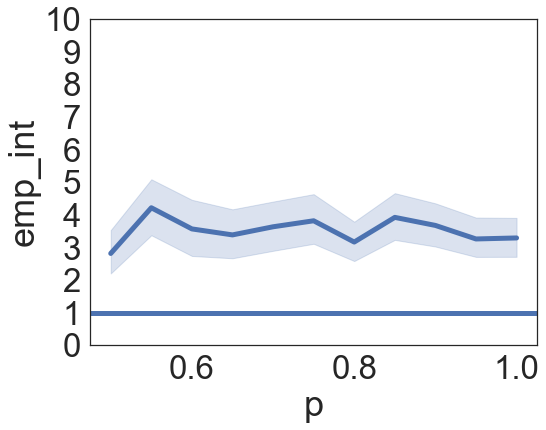

In [285]:
sns.set(font_scale=3)
sns.set_style("white")

ax = sns.lineplot(data=df_emp_int, x="p", y="emp_int", lw=5)
ax.set_yticks(range(0, 11))
#ax.set_xticks([0.5, 0.75, 1])
ax.set_ylim([0, 10])
#ax.set_xlim([.5, 1.1])

plt.legend([],[], frameon=False)
ax.axhline(1, lw = 5)

#ax.set_title("Alice receives less error than Bob with higher p", 
#            pad=15)
#ax.set_xlabel('p')
#ax.set_ylabel('% Answered Accurately')

artifacts_path = '/Users/albertsun/Projects/artifacts/'

#txt="Run on practical workloads with t=500 trials each \nusing Private Multiplicative Weights (Hardt 2010)"
#plt.figtext(0.53, -0.05, txt, wrap=True, horizontalalignment='left', fontsize=15)

plt.savefig(artifacts_path + "MotivatingEmpInt.png")

In [ ]:
means = {}
for p in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]:
    print(f'calc means for {p}')
    
    list_diffs = motivating_exp(p, 100)
    means[p] = sum(list_diffs) / len(list_diffs)

In [ ]:
df_means = pd.DataFrame.from_dict(means, 
                      orient='index')
df_means = df_means.reset_index()
df_means = df_means.rename(columns={0:'Practical'})

In [ ]:
import seaborn as sns
from matplotlib import rcParams
import matplotlib as mpl

# size
rcParams['figure.figsize'] = 12, 8


# figure size in inches
#sns.set_context("journal")
#sns.set_context("notebook")

# font size
sns.set(font_scale = 2)

#theme
sns.set_style("ticks")

#sns.set_theme()

# plot and labels
ax = sns.lineplot(data=df_means, x="index", y="Practical")
ax.set_ylim([-1, 1])
ax.set_title("Alice receives greater accuracy compared to Bob\nthe earlier her queries are answered", 
            pad=15)
ax.set_xlabel('P(Alice asks a query)')
ax.set_ylabel('TotalErr(Bob) - TotalErr(Alice)')

# alice and bob annottaions
ticklabelpad = mpl.rcParams['xtick.major.pad']
ax.annotate('Alice', xy=(-0.15,1.1), xytext=(5, -ticklabelpad), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')
ax.annotate('Bob', xy=(-0.15,-0.05), xytext=(5, -ticklabelpad), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')

artifacts_path = '/Users/albertsun/Projects/artifacts/'

txt="Run on practical workloads with t=500 trials each \nusing Private Multiplicative Weights (Hardt 2010)"
plt.figtext(0.53, -0.05, txt, wrap=True, horizontalalignment='left', fontsize=15)

plt.savefig(artifacts_path + "MotivatingExp.png")



In [ ]:
random_array = np.random.randint(2, size=(100,32))
zero_array = np.zeros((100,32))
disjoint_alice_q = np.hstack((random_array, zero_array))
disjoint_bob_q = np.hstack((zero_array, random_array))

disjoint_alice_q

In [ ]:
def disjoint_motivating_exp(p, t):
    diff_lst=[]
    database = x_race[:64]
    for i in range(t):
        # generate disjoint workloads
        random_array = np.random.randint(2, size=(100,32))
        zero_array = np.zeros((100,32))
        disjoint_alice = np.hstack((random_array, zero_array))
        disjoint_bob = np.hstack((zero_array, random_array))
        
        # Shuffle and generate workload/analyst labels using Skewed Scheduler()
        W, analyst_labels = skewed_scheduler(disjoint_alice, disjoint_bob, p)
            
        # PMW calculate error
        error_dict = pmw_naive(W, database, analyst_labels, eps=1, T=40, to_return='error')

        # subtract errors to get difference
        diff =  error_dict['B'] - error_dict['A']
        # append difference to list for this specific p
        diff_lst.append(diff)

    return diff_lst

In [ ]:
random_array = np.random.randint(2, size=(100,32))
zero_array = np.zeros((100,32))
disjoint_alice = np.hstack((random_array, zero_array))
disjoint_bob = np.hstack((zero_array, random_array))

W, analyst_labels = skewed_scheduler(disjoint_alice, disjoint_bob, p)



In [ ]:
disjoint_means = {}
for p in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]:
    print(f'calc means for {p}')
    list_diffs = disjoint_motivating_exp(p, 100)
    disjoint_means[p] = sum(list_diffs) / len(list_diffs)

In [ ]:
df_disjoint_means = pd.DataFrame.from_dict(disjoint_means, 
                      orient='index')
df_disjoint_means = df_disjoint_means.reset_index()
df_disjoint_means = df_disjoint_means.rename(columns={0: 'Disjoint'})

df_disjoint_means

In [ ]:
merged = pd.merge(df_means, df_disjoint_means, on='index')
merged = merged.rename(columns={'index':'p'}).set_index('p')
merged

In [ ]:
disjoint_alice_q

In [ ]:
disjoint_bob_q

In [ ]:
# plot and labels
ax = sns.lineplot(data=merged)
ax.set_ylim([-1.5, 1.5])
ax.set_title("Alice receives less error the earlier her queries are answered", 
            pad=15)
ax.set_xlabel('P(Alice asks a query)')
ax.set_ylabel('Err(Bob) - Err(Alice)')

# alice and bob annottaions
ticklabelpad = mpl.rcParams['xtick.major.pad']
ax.annotate('Alice', xy=(-0.15,1.1), xytext=(5, -ticklabelpad), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')
ax.annotate('Bob', xy=(-0.15,-0.05), xytext=(5, -ticklabelpad), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')

artifacts_path = '/Users/albertsun/Projects/artifacts/'

txt="Run on practical workloads with t=500 trials each \nusing Private Multiplicative Weights (Hardt 2010)"
plt.figtext(0.53, -0.05, txt, wrap=True, horizontalalignment='left', fontsize=15)

plt.savefig(artifacts_path + "BothMotivatingExp.png")



In [ ]:
means_dic={}

In [ ]:
diff_pointfive = motivating_exp(0.5, t=100)

In [ ]:
plt.hist(diff_pointfive)
plt.title("Err(Bob) - Err(Alice) when p = 0.5")
plt.show()
print(f'Mean = {sum(diff_pointfive) / len(diff_pointfive)}')

In [ ]:
diff_pointsevenfive = motivating_exp(0.75, t=100)

In [ ]:
plt.hist(diff_pointsevenfive)
plt.title("Err(Bob) - Err(Alice) when p = 0.75")
plt.show()
print(f'Mean = {sum(diff_pointsevenfive) / len(diff_pointsevenfive)}')

In [ ]:
diff_one = motivating_exp(1, t=100)

In [ ]:
plt.hist(diff_one)
plt.title("Err(Bob) - Err(Alice) when when p = 1")
plt.show()
print(f'Mean = {sum(diff_one) / len(diff_one)}')

As p increases, Alice gets to answer more of her queries earlier, resulting in her having less and less error compared to Bob. 

As you can see, 

- in the p=0.5 setting, Bob has 0.016169999999999983 more error than Alice.
- in the p=0.75 setting, Bob has 0.3576099999999998 more error than Alice. 
- in the p=1 setting, Bob has 0.43591 more error than Alice. 

# Workload Constructor (WIP)

In [ ]:
# WIP: 4-12-2022

import string
alphabet = list(string.ascii_lowercase)
alphabet

W_lst = [online_workloads.identity(n), online_workloads.total(n), online_workloads.race1(), online_workloads.race2(), online_workloads.race3(), online_workloads.custom(n), online_workloads.prefix_sum(n)]


W_lst = [online_workloads.identity(n)]
W_name = ['identity']

def workload_selection(W_lst, W_name, k, analyst_names=None):
    """
    Create a workload
    
    W_lst = Workload list
    W_name = Workload name
    k = number of analysts
    analyst_names = Analyst names, default = lowercase alphabet letters (i.e. analysts 'a', 'b', etc.)
    """
    
    if analyst_names == None:
        #if analyst_names: 
        #    raise TypeError("a and b dimensions don't match")
        #else: 
        analyst_names = alphabet[:k]
    
    Wn = []
    analyst_labels = []
    
    c = np.random.randint(len(W_lst))
    Ws = W_lst[c]
    Wn.append(W_name[c])
    
    #for i in range(len(analyst_names) - 1):
    #    c = np.random.randint(len(W_lst))
    #    Ws = Ws.vstack(Ws, W_lst[c])
    #    Wn.append(W_name[c])
    return Ws, Wn, analyst_labels

workload_selection(W_lst, W_name, 2)


# other WIP attemps: 


n=64
W_name = ['identity', 'total', 'H2', 'race1', 'race2', 'race3', 'custom', 'prefix_sum']
W_lst = [online_workloads.identity(n), online_workloads.total(n), online_workloads.H2(n), online_workloads.race1(), online_workloads.race2(), online_workloads.race3(), online_workloads.custom(n), online_workloads.prefix_sum(n)]

c = np.random.randint(len(W_lst))
final_W = W_lst[c] 

t = 10
for i in range(t): 
    c = np.random.randint(len(W_lst))
    print(c)
    final_W = np.vstack((final_W, W_lst[c]))
    
print(len(final_W))

final_W



In [ ]:
# initialize databases

import pandas as pd
data_path = "migration_tworace.csv"
#x_race = pd.read_csv(data_path, header=None).iloc[:, 1].to_numpy()
n = x_race.shape[0]
x_race

x_example = np.array([1000, 2000, 3000, 4000, 5000])
new_x = np.array([.1, .15, .2, .25, .3]) * 1500

In [ ]:
x_race_first_ten = x_race[:10]

# try identity on the race database
data = pmw_naive(hundred_identity_q, x_race_first_ten, ['A'] * 1000, eps=10, T=40, total_k = 100, 
          show_messages=True, to_return = 'pd')#to_return='tse')
data
data['abs_error'].sum() / len(data)